## Pipeline Strategy

1. Load & Combine Data 
2. Preprocess Text (No Stemming or Lemmatization here!) 
3. Tokenize Sentences
4. Train Word2Vec Model
5. Average Word Embeddings per Article
6. Train-Test Split
7. Train Logistic Regression
8. Evaluate

# Step 1: Import Libraries

In [3]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 2: Load & Combine Data

In [4]:
# 2A. Load Datasets
fake_df = pd.read_csv('../data/Fake.csv')
real_df = pd.read_csv('../data/True.csv')

# 2B. Add Labels
fake_df['label'] = 1  # Fake news
real_df['label'] = 0  # Real news

# 2C. Combine Datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# 2D. Drop duplicate articles based on 'text' only
print("Duplicates before dropping:", df.duplicated(subset='text').sum())
df = df.drop_duplicates(subset='text')
print("Remaining duplicates after dropping:", df.duplicated(subset='text').sum())

# 2E. Shuffle and keep only necessary columns
df = df.sample(frac=1).reset_index(drop=True)
df = df[['text', 'label']]
df.dropna(inplace=True)

# 2F. Check sample size and label distribution
print(f"\n✅ Total Cleaned Samples: {len(df)}")
print("Class Distribution:\n", df['label'].value_counts())
df.head()

Duplicates before dropping: 6252
Remaining duplicates after dropping: 0

✅ Total Cleaned Samples: 38646
Class Distribution:
 label
0    21191
1    17455
Name: count, dtype: int64


,text,label
0,WASHINGTON (Reuters) - The U.S. Senate will vo...,0
1,BAGHDAD (Reuters) - The semi-autonomous Kurdis...,0
2,WASHINGTON (Reuters) - Americans are more like...,0
3,TEGUCIGALPA (Reuters) - Honduras electoral tr...,0
4,BANGKOK (Reuters) - Thailand will hold a gener...,0


# Step 3: Text Preprocessing Function

In [7]:
# 3A. Define Preprocessing Function

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# 3B. Apply Preprocessing

df['tokens'] = df['text'].apply(preprocess)
    

# Step 4: Train Word2Vec Model

In [8]:
sentences = df['tokens'].tolist()

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Step 5: Convert Each Article to an Averaged Vector

In [9]:
def get_average_vector(tokens, model, vector_size):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

vector_size = 100
X = np.array([get_average_vector(tokens, w2v_model, vector_size) for tokens in df['tokens']])
y = df['label'].values

# Step 6: Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 46)

# Step 7: Model Training (Logistic Regression)

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# Step 8: Evaluation

In [12]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9789133247089262

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4285
           1       0.98      0.97      0.98      3445

    accuracy                           0.98      7730
   macro avg       0.98      0.98      0.98      7730
weighted avg       0.98      0.98      0.98      7730


Confusion Matrix:
 [[4212   73]
 [  90 3355]]


# Visualization for Word2Vec: Word Embedding

/opt/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


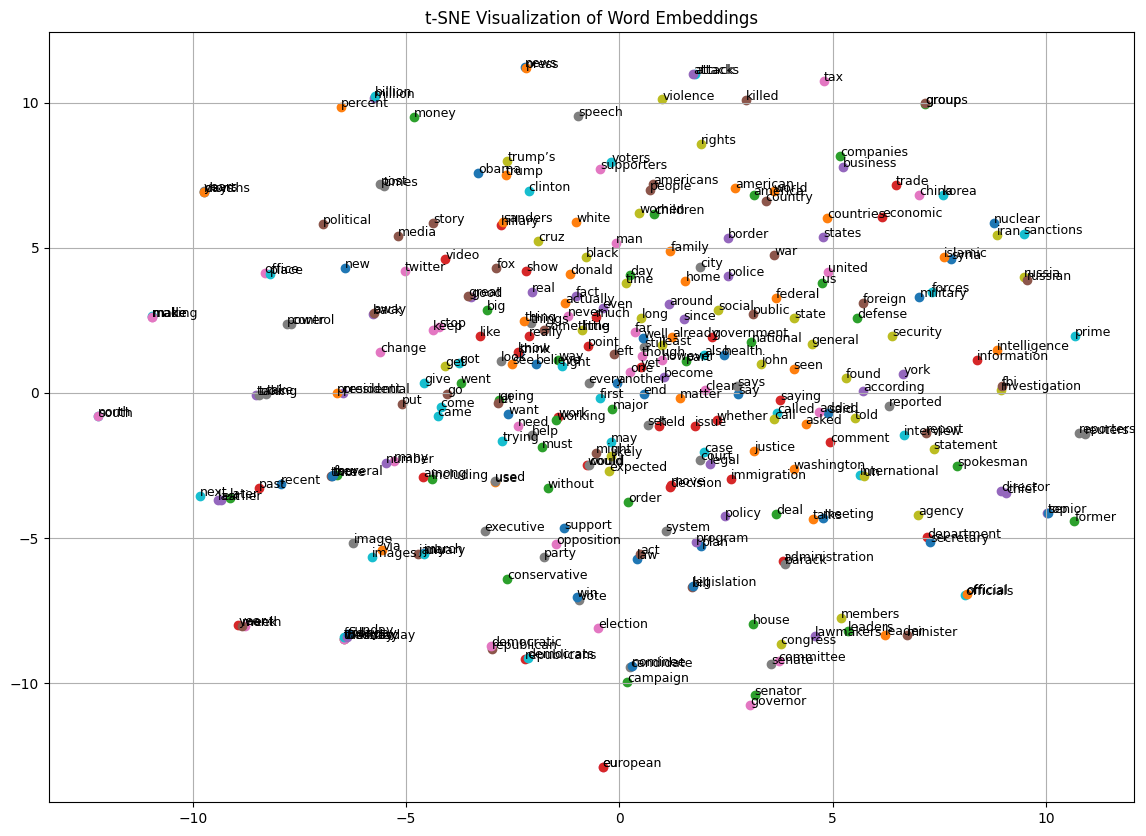

In [15]:
from sklearn.manifold import TSNE
import random

# Limit to top 300 frequent words for visualization
top_words = w2v_model.wv.index_to_key[:300]
word_vectors = np.array([w2v_model.wv[word] for word in top_words])

# Reduce 100D → 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
word_vec_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(14, 10))
for i, word in enumerate(top_words):
    x, y = word_vec_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)
plt.title("t-SNE Visualization of Word Embeddings")
plt.grid(True)
plt.show()